In [1]:
from keras.models import load_model
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import os

2022-12-16 00:34:38.206144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 00:34:39.334344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/external/libraries/cudnn-linux-x86_64-8.4.1.50_cuda11.6-archive/lib:/sw/spack/delta-2022-03/apps/cuda/11.6.1-gcc-11.2.0-vglutoe/extras/CUPTI/lib64:/sw/spack/delta-2022-03/apps/cuda/11.6.1-gcc-11.2.0-vglutoe/lib64:/sw/spack/delta-2022-03/apps/openmpi/4.1.2-gcc-11.2.0-37px7gc/lib:/sw/spack/delta-2022-03/apps/ucx/1.11.2-gcc-11.2.0-pymppfm/lib:/sw/spack/delta-2022-03/apps/gcc/11.2.0-gcc-8.4.1-fxgns

In [2]:
## List of models
all_models = [f for f in os.listdir("../../models/TopoDNN/trained_models/")]
print("\n".join(all_models))

topodnnmodel_pt
topodnnmodel_pt0
topodnnmodel_v3
topodnnmodel_standardize_pt
topodnnmodel_30
topodnnmodel_v1
topodnnmodel_v2
topodnnmodel_v4
topodnnmodel


In [3]:
#Loading data
df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")

#Can change to '', '_pt0','_pt', '_30', or '_standardize_pt'
mode = ''
#Load model
model = load_model("../../models/TopoDNN/trained_models/topodnnmodel"+mode)


2022-12-16 00:34:42.078243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 00:34:42.570866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38261 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               27300     
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               30702     
                                                                 
 activation_1 (Activation)   (None, 102)               0         
                                                                 
 dense_2 (Dense)             (None, 12)                1236      
                                                                 
 activation_2 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 7

In [5]:
for ii, layer in enumerate(model.layers):
    print(ii, layer)

0 <keras.layers.core.dense.Dense object at 0x7fc678623880>
1 <keras.layers.core.activation.Activation object at 0x7fc667085d60>
2 <keras.layers.core.dense.Dense object at 0x7fc667085d90>
3 <keras.layers.core.activation.Activation object at 0x7fc6640f5670>
4 <keras.layers.core.dense.Dense object at 0x7fc6640f5760>
5 <keras.layers.core.activation.Activation object at 0x7fc6640f5f40>
6 <keras.layers.core.dense.Dense object at 0x7fc6640fc070>
7 <keras.layers.core.activation.Activation object at 0x7fc6640fc850>
8 <keras.layers.core.dense.Dense object at 0x7fc6640fc940>
9 <keras.layers.core.activation.Activation object at 0x7fc6640f7160>


In [11]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.nanquantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr',
# save details whether you want to save it or not
def make_graphs(model, mode, df_test, part_dataset, zero_bias=False, lrp_type='zero', lrp_param=None,
               graphs=['abs_bar', 'bar', 'dist', 'corr_matrix'], figsize=(10, 10), options = '', extra_name=False, save=False):
    if extra_name:
        if zero_bias:
            options += '_zero_bias'
        if lrp_type == 'gamma':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'epsilon':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'zero':
            options += '_LRP-' + lrp_type
    if part_dataset == 'sig':
        X = df_test.loc[df_test['is_signal_new'] == 1, df_test.columns != 'is_signal_new']
    elif part_dataset == 'bkg':
        X = df_test.loc[df_test['is_signal_new'] == 0, df_test.columns != 'is_signal_new']
    elif part_dataset == 'all':
        X = df_test.loc[:, df_test.columns != 'is_signal_new']

    if mode == '_pt0':
        #Get rid of pt_0 column
        X = X.loc[:, X.columns != 'pt_0']
    elif mode == '_pt':
        pt_cols = [col for col in X.columns if 'pt' in col]
        X = X.drop(pt_cols, axis=1)
    elif mode == '_30':
        X = X.iloc[:,:30]
    elif mode == '_standardize_pt':
        pt_cols = [col for col in X.columns if 'pt' in col]
        X[pt_cols] = (X[pt_cols] - X[pt_cols].mean())/X[pt_cols].std()
        
    if  'average_feats' in options:
        X[X.columns] = X[X.columns].mean()*(X[X.columns] + 1.e-9)/(X[X.columns] + 1.e-9)

    classes = X.columns #column names
    L= len(model.layers) #num layers
    layers = model.layers
    A = [X]+[None]*L
    A[0] = tf.convert_to_tensor(A[0])
    
    #Calculates model's steps
    idx = 0
    for layer in model.layers:
        #g=layer.get_config()['name']
        #act = layer.get_config()['activation']
        #h=layer.get_weights()
        A[idx+1]=layer(A[idx])
        idx+=1
    #Clones model
    cloned_model = keras.models.clone_model(model)
    cloned_model.set_weights(model.get_weights())
    cloned_layers = cloned_model.layers
    #Combine Dense+Activation functions
    B = [A[0], A[2], A[4], A[6], A[8], A[10]]
    # Backpropagate relevance scores (LRP-gamma)
    if lrp_type == 'zero':
        rho = lambda p: p;                       incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*tf.nn.relu(p); incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p;                       incr = lambda z: z+lrp_param
    R = [None]*5 + [B[-1]]
    # Iterate over the layers in reverse order
    for l in range(0,5)[::-1]:
        with tf.GradientTape() as tape:
            tape.watch(B[l])
            #Transform weights
            cloned_layers[2*l].set_weights([rho(cloned_layers[2*l].get_weights()[0]), rho(cloned_layers[2*l].get_weights()[1])])
            #Execute forward pass
            z = cloned_layers[2*l](B[l])
            if l != 4:
                z = incr(cloned_layers[2*l+1](z))
            else:
                z = incr(z)
            #Gets rid of zeroes in denominators
            inds_nz = z != 0
            #print(tf.reshape(z, [-1]).shape, tf.reduce_sum(tf.cast(inds_nz, tf.float32)))
            R1_sum = tf.reduce_sum(R[l+1])
            R2_sum_nz = tf.reduce_sum(R[l+1][inds_nz])
            R[l+1] = R[l+1]*R1_sum/R2_sum_nz
            #print(R1_sum/R2_sum_nz)
            z = tf.where(tf.identity(z) == 0, 1, z)
            R[l + 1] = tf.where(tf.identity(z) == 0, 0, R[l+1])
            # Element-wise division between relevance of the next layer and z
            s = (R[l+1]/z)


            s = tf.reshape(s, z.shape)
            # Calculate the gradient and multiply it by the activation
            c = tape.gradient(tf.reduce_sum(z*s.numpy()), B[l])
            # Assign new relevance values
            R[l] = (B[l]*c)
            
    
    #Plots relevances as normalized
    normal_rel = np.empty_like(R[0])
    #Normalizes relevances for each sample
    normal_rel = (R[0]/np.sum(R[0], 1)[:, np.newaxis]).numpy()
    #print(R[0])
    #print(normal_rel)
    normal_rel_no_outlier = removeOutliers(normal_rel)
    if part_dataset == 'sig': 
        type_set = 'Signal'
    else: 
        type_set = 'Background'
    idx=0
    if 'abs_bar' in graphs:
        print('abs_bar')
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("Mean |Relevance Score|", fontsize=30)
        if  'average_feats' in options:
            plt.xlabel("|Mean-Behavior Relevance Score|", fontsize=30)
        plt.ylabel("Features", fontsize=30)
        plt.tick_params(axis='x', which='major', labelsize=30)
        plt.tick_params(axis='y', which='major', labelsize=31)
        if part_dataset == 'bkg':
            plt.text(0.15, 2, "background", fontsize=30, bbox=dict(boxstyle='Square', facecolor='white'))
        if part_dataset == 'sig':
            plt.text(0.06, 2, "signal", fontsize=30, bbox=dict(boxstyle='Square', facecolor='white'))
        ticks = [f.get_text() for f in plt.yticks()[1]]
        tag_labels = []
        for tag in ticks:
            if 'pt' in tag:
                tag = tag.replace('_','').replace('pt','p_{t,') + '}'
            tag_labels.append('$' + tag.replace('phi', '\phi').replace('eta', '\eta').replace('_', '_{') + '}$' )
        plt.yticks(np.arange(0,max_display,1),tag_labels,fontsize=31)
        #plt.title("TopoDNN Absolute Value "+type_set+" LRP values")
        idx+=1
        plt.tight_layout()
        if save:
            plt.savefig("figures/LRP_TopoDNN"+mode+"_"+part_dataset+"_absbar"+options+".png", 
                        dpi = 150)
        plt.show()
        if idx == len(graphs):
            return classes, normal_rel_no_outlier
    if 'bar' in graphs:
        # normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(normal_rel_no_outlier, 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.xlabel("Mean Relevance Score", fontsize=20)
        plt.ylabel("Features", fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=20)
        # plt.title("TopoDNN "+type_set+" LRP values")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/LRP_TopoDNN"+mode+"_"+part_dataset+"_bar"+options+".png", 
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return classes, normal_rel_no_outlier
#     if 'dist' in  graphs:
#         normal_rel_no_outlier = removeOutliers(normal_rel)
#         plt.figure(idx, figsize=figsize)
#         shap.summary_plot(normal_rel_no_outlier, X, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
#         plt.title("TopoDNN "+type_set+" LRP values")
#         plt.gcf().axes[-1].set_aspect(100)
#         plt.gcf().axes[-1].set_box_aspect(100)
#         plt.tight_layout()
#         idx+=1
#         if save:
#             plt.savefig("figures/TopoDNN"+mode+"/LRP_"+part_dataset+"_dist"+options+".png", dpi = 150, bbox_inches='tight')
#         plt.show()
#         if idx == len(graphs):
#             return
    if 'corr' in graphs:
        print('corr')
        # normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes).iloc[: , :30]
        df_rel_total = df_rel_total.loc[:, ~df_rel_total.columns.isin(["phi_0", "eta_0"])]
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        # plt.title("TopoDNN "+type_set+" LRP Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/LRP_TopoDNN"+mode+"_"+part_dataset+"_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return classes, normal_rel_no_outlier
    if 'feature_corr' in graphs:
        print('feature_corr')
        plt.figure(idx, figsize=figsize)
        df_rel_total = X.iloc[: , :30]
        corrmat = df_rel_total.loc[:, ~df_rel_total.columns.isin(["phi_0", "eta_0"])].corr()
        ax = sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        # plt.title("TopoDNN "+type_set+" Correlation Matrix")
        ticks = [f.get_text() for f in plt.yticks()[1]]
        tag_labels = []
        for tag in ticks:
            if 'pt' in tag:
                tag = tag.replace('_','').replace('pt','p_{t,') + '}'
            tag_labels.append('$' + tag.replace('phi', '\phi').replace('eta', '\eta').replace('_', '_{') + '}$' )
        plt.yticks(np.arange(0,28,1)+0.5,tag_labels,fontsize=15)
        plt.xticks(np.arange(0,28,1)+0.5,tag_labels,fontsize=15)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/FeatCorr_TopoDNN"+mode+"_"+part_dataset+options+".png", 
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return classes, normal_rel_no_outlier
    if 'box_whisker' in graphs:
        print('box_whisker')
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(normal_rel, columns=classes)
        df_rel_total = df_rel[sorted_index[:20]]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        plt.tick_params(axis='both', which='major', labelsize=20)
        #plt.title("TopoDNN "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/LRP_TopoDNN"+mode+"_"+part_dataset+"_boxwhisker"+options+".png", 
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return classes, normal_rel_no_outlier
    print("Not applicable graph type")
    return classes, normal_rel_no_outlier


abs_bar


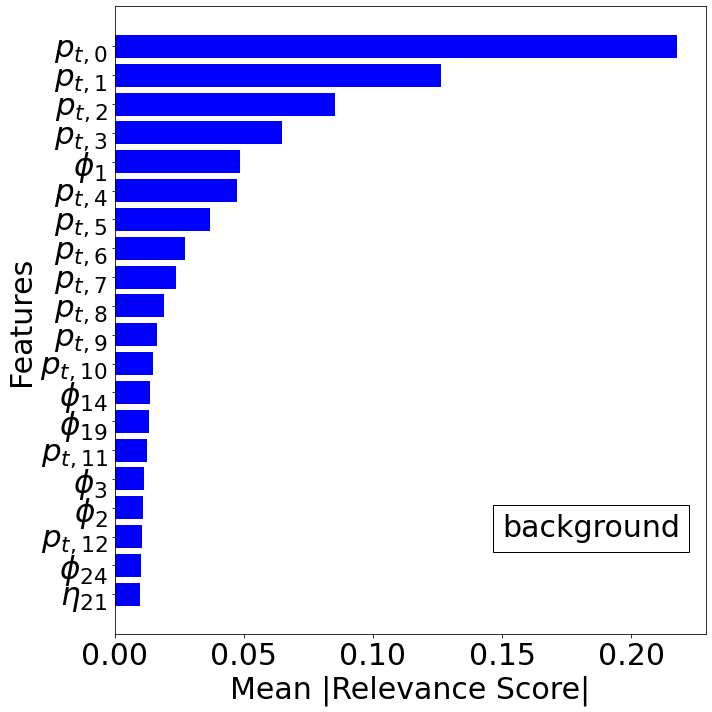

feature_corr


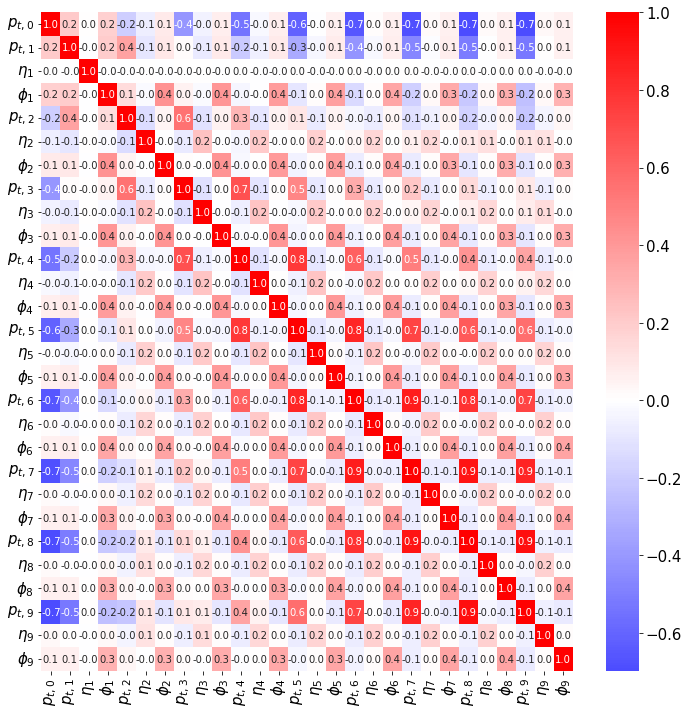

abs_bar


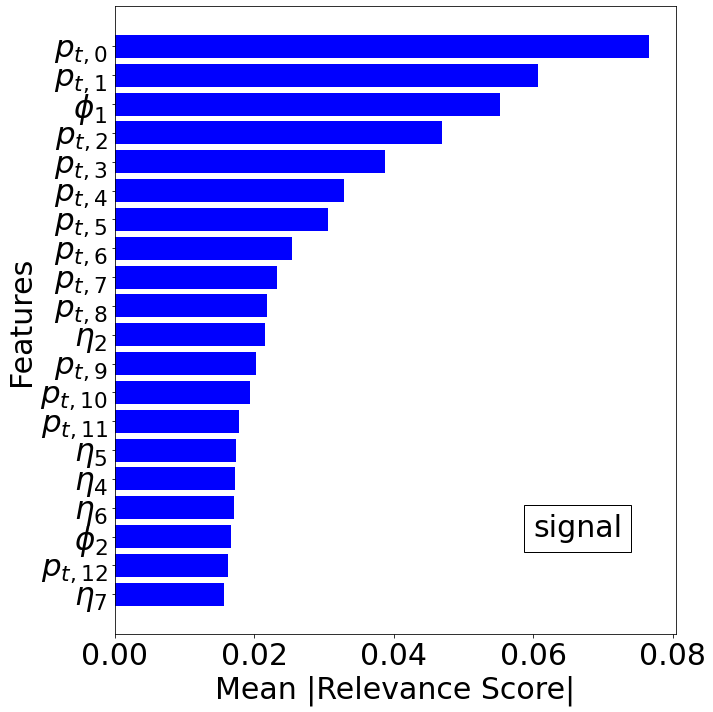

feature_corr


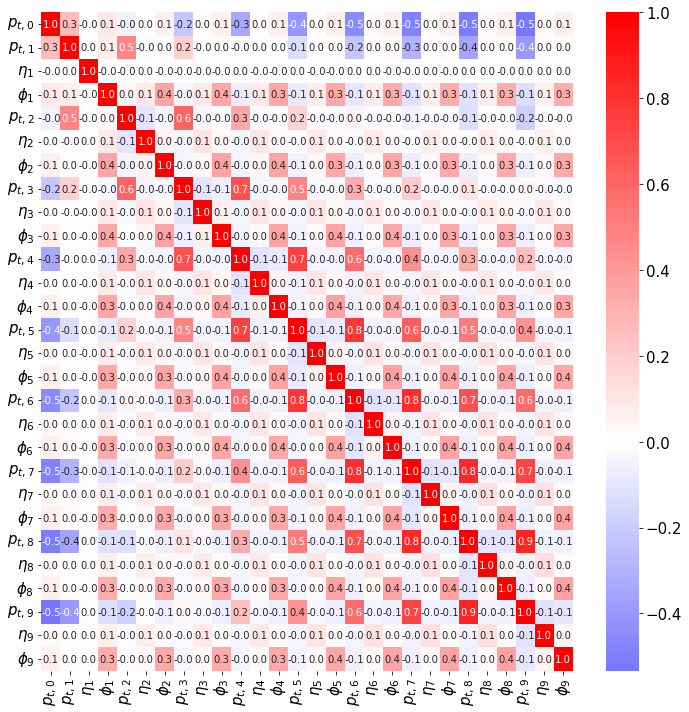

In [12]:
#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#N, use_jet_pt, use_jet_mass are taken from parameters
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist','corr'
# save details whether you want to save it or not
#figsize is the figure size of all plots, options are extra names you can add to end of saved figure 
#when specifying options, suggested to put '_' before the word
#extra_name specifies what LRP type automatically when saving
part_dataset = 'bkg'
mode=mode
zero_bias=False
lrp_type='gamma'
lrp_param=2
graphs=['abs_bar', 'feature_corr']
figsize=(10, 10)
options = ''
save=True
extra_name=False

classes, rel_bkg = make_graphs(model=model, mode=mode, df_test=df_test, 
                      part_dataset='bkg', zero_bias=zero_bias, 
                      lrp_type=lrp_type, lrp_param=lrp_param, graphs=graphs,
                      figsize=figsize, options=options, extra_name=extra_name, save=save)
classes, rel_sig = make_graphs(model=model, mode=mode, df_test=df_test, 
                      part_dataset='sig', zero_bias=zero_bias, 
                      lrp_type=lrp_type, lrp_param=lrp_param, graphs=graphs,
                      figsize=figsize, options=options, extra_name=extra_name, save=save)

/tmp/ipykernel_2630513/3829650884.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X.columns] = X[X.columns].mean()*(X[X.columns] + 1.e-9)/(X[X.columns] + 1.e-9)


abs_bar


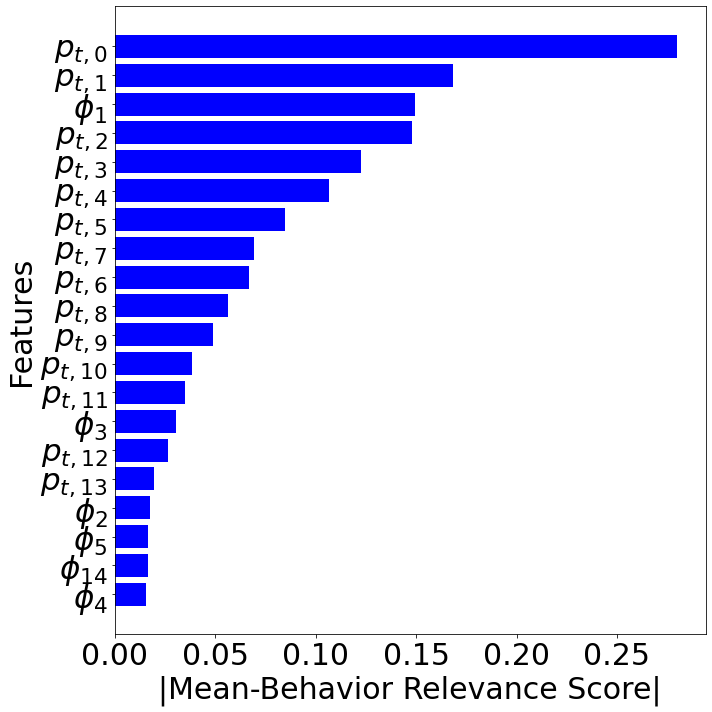

In [13]:
classes, rel_0 = make_graphs(model=model, mode=mode, df_test=df_test, 
                        part_dataset='all', zero_bias=zero_bias, 
                        lrp_type=lrp_type, lrp_param=lrp_param, graphs=['abs_bar'],
                        figsize=figsize, options='_average_feats', extra_name=extra_name, save=save)